# 2次計画法でFIRフィルタを設計する
FIRフィルタの設計問題を2次計画問題に帰着して解きます。
ソルバにはpythonの凸最適化問題モデリングライブラリCVXPYを使いました。


### 参考
* CVXPY
    + [ドキュメント](https://www.cvxpy.org/)
    + 凸最適化問題モデリングライブラリです。
        - 数式をソルバの要求する形式（restrictive standard form）に変換して、ソルバを使って問題を解くライブラリです。
        - 内部でオープンソースソルバ [ECOS](https://github.com/embotech/ecos), [OSQP](https://osqp.org/), [SCS](https://github.com/cvxgrp/scs)を使っています。
    + 今回はCVXPYで2次計画問題（QP）を解きました。CVXPYはそれ以外にも半正定値計画問題や混合整数2次計画問題も解けるようです。
* 2次計画法を使ったFIRフィルタの設計
    + [Design of Digital Filters And Filter Banks By Optimization: A State Of The Art Review](https://zenodo.org/record/37691#.YHRboBJUuf8) 
    + 2.1を参考にしました。


## FIRフィルタとは
* Finite Impulse Response（有限インパルス応答）フィルタ。時系列データ（信号）を整形するデジタルフィルタの一種です。
* 移動平均フィルタが有名です。
    + 株価、感染者数、etc.
* （todo もうすこし書きたい）

ライブラリのインポート

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cvxpy as cp
import scipy
import matplotlib

from scipy import signal
import matplotlib.pyplot as plt

print(f'{np.__version__=}, {cp.__version__=}, {scipy.__version__=}, {matplotlib.__version__=}')

np.__version__='1.20.2', cp.__version__='1.1.11', scipy.__version__='1.6.2', matplotlib.__version__='3.4.1'


## 2次計画法を用いたFIRフィルタの設計
次の2次計画問題を解くと、所望の周波数特性をもつFIRフィルタを設計することができます。

$$
\text{minimize} \quad (1/2)x^TQ_lx + b_l^Tx \\ 
\text{subject to} \quad Gx \leq h.
\tag{1}
$$

詳しくは[末尾](#設計手法の詳細)に書きました。

### ローパスフィルタを設計する
FIRフィルタの基本的なパラメータを定義します。今回の手法では、フィルタ次数$N$は奇数である必要があります。

In [3]:
N = 101 # フィルタ次数
Ts = 1e-3 # 制御周期 [s]

M = (N-1) // 2 # (N-1)/2

---

$\omega_p$以下の周波数では通過、$\omega_a$以上の周波数では遮断するフィルタを設計します（$\omega_p,\omega_a$は正規化周波数）。
$A_d(\omega)$と$W(\omega)$を以下のように定義します。

$$
A_d(\omega)=
\begin{cases}
1 & \text{if }0 \le \omega \le \omega_p,\\
0 & \text{if }\omega_p \le \omega \le \omega_a,\\
0 & \text{if }\omega_a \le \omega \le \pi.
\end{cases}
$$

$$
W(\omega)=
\begin{cases}
1 & \text{if }0 \le \omega \le \omega_p,\\
0 & \text{if }\omega_p \le \omega \le \omega_a,\\
\gamma & \text{if }\omega_a \le \omega \le \pi.
\end{cases}
$$

このとき(1)式の$Q_l$と$b_l$は

$$
Q_l
= \int_{0}^{\pi}{W(\omega)c_l(\omega)c_l^T(\omega) \ d\omega}
= \int_{0}^{\omega_p}{c_l(\omega)c_l^T(\omega) \ d\omega}
+ \gamma \int_{\omega_a}^{\pi}{c_l(\omega)c_l^T(\omega) \ d\omega},
$$

$$
b_l
= \int_{0}^{\pi}{W(\omega)A_d(\omega)c_l(\omega) \ d\omega}
= \int_{0}^{\omega_p}{c_l(\omega) \ d\omega}.
$$

になります。ここで、$c_l(x)=[1, \cos\omega, \cos 2 \omega, ... , \cos ((N-1)\omega/2)]^T$です。

---
例として、周波数が10 Hz以下の信号を通過、30 Hz以上の信号を遮断するフィルタを設計します。
正規化周波数は、周波数（単位：Hz） に$2 \pi T_s$を乗算して求めます。


In [4]:
gamma = 10 #重み

omega_p = 10 *2*np.pi*Ts # 10 [Hz] * 2 pi Ts
omega_a = 30 *2*np.pi*Ts # 20 [Hz] * 2 pi Ts

#### $Q_l$を計算する

---

$$
Q_l = \int_{0}^{\omega_p}{c_l(\omega)c_l^T(\omega) \ d\omega} + \gamma \int_{\omega_a}^{\pi}{c_l(\omega)c_l^T(\omega) \ d\omega}.
$$

行列の成分毎に計算します。$i$行$j$列目の成分は次のようになります（インデックスは0始まりです）

$$
\left[ \int_{\omega_0}^{\omega_1}{c_l(\omega)c_l^T(\omega) \ d\omega} \right]_{ij}
= \int_{\omega_0}^{\omega_1}{\cos i\omega \cos j\omega \ d\omega}
$$

$i=j=0$の場合
$$
\int_{\omega_0}^{\omega_1}{1 \ d\omega} = \omega_1 - \omega_0
$$

$i\neq 0$ または $j \neq 0$の場合

$$
\int_{\omega_0}^{\omega_1}{ \frac{1}{2} \left[ \cos(i+j)\omega+\cos(i-j)\omega \right] \ d\omega}
$$

なので、
$i\neq 0$ または $j \neq 0$、かつ$i=j$の場合

$$
\frac{1}{2}
\left[
\frac{1}{(i+j)}
\sin(i+j)\omega
+ \omega 
\right]^{\omega_1}_{\omega_0}
$$

$i\neq 0$ または $j \neq 0$、かつ$i \neq j$の場合

$$
\frac{1}{2}
\left[
\frac{1}{i+j}
\sin(i+j)\omega
+
\frac{1}{i-j}
\sin(i-j)\omega
\right]^{\omega_1}_{\omega_0}
$$
    
---

In [5]:
# Q_l計算
Q_l = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        if i == 0 and j == 0:
            # 0 ~ \omega_p
            comp = omega_p - 0.0
            # \omege_a ~ \pi
            comp += gamma * (np.pi - omega_a)
        else: #if i != 0 or j != 0
            if i == j:
                # 0 ~ \omega_p
                comp = 0.5 * (1/(i+j)*np.sin((i+j)*omega_p) + omega_p)
                comp -= 0.5 * (1/(i+j)*np.sin((i+j)*0.0) + 0.0)
                # \omege_a ~ \pi
                comp += gamma*0.5 * (1/(i+j)*np.sin((i+j)*np.pi) + np.pi)
                comp -= gamma*0.5 * (1/(i+j)*np.sin((i+j)*omega_a) + omega_a)
            else:
                # 0 ~ \omega_p
                comp = 0.5 * (1/(i+j)*np.sin((i+j)*omega_p) + 1/(i-j)*np.sin((i-j)*omega_p))
                comp -= 0.5 * (1/(i+j)*np.sin((i+j)*0.0) + 1/(i-j)*np.sin((i-j)*0.0))
                # \omege_a ~ \pi
                comp += gamma*0.5 * (1/(i+j)*np.sin((i+j)*np.pi) + 1/(i-j)*np.sin((i-j)*np.pi))
                comp -= gamma*0.5 * (1/(i+j)*np.sin((i+j)*omega_a) + 1/(i-j)*np.sin((i-j)*omega_a))
        
        # 格納
        Q_l[i, j] = comp


#### $b_l$を計算する

---

$$
b_l
= \int_{0}^{\omega_p}{c_l(\omega) \ d\omega}.
$$

$Q_l$と同様に成分毎に計算します。

$$
\left[
    \int_{\omega_0}^{\omega_1}
    {
        c_l(\omega)
        \ d\omega
    }
\right]_{i}
=
\int_{\omega_0}^{\omega_1}
{
    \cos i \omega
    \ d\omega
} \\
$$

$i = 0$の場合

$$
\omega_1 - \omega_0
$$


$i \ne 0$の場合

$$
\frac{1}{i}
\left[
    \sin i \omega
\right]^{\omega_1}_{\omega_0}
$$

---

In [6]:
# b_l計算
b_l = np.zeros(M)
for i in range(M):
    if i == 0:
        # 0 ~ \omega_p
        b_l[i] = omega_p - 0.0
    else:
        # 0 ~ \omega_p
        b_l[i] = 1/i*(np.sin(i*omega_p) - np.sin(i*0.0))


#### 制約条件

---
$\delta_p \ge 0$に対して、次の制約を課します

$$
|A(\omega)-1| \le \delta_p \hspace{5pt} \text{for} \ \omega \in [0, \omega_p].
$$

実装上は、サンプル周波数の集合$S_p=\{\omega_i^{(p)},\ i=1,...,M_p\}$を導入して、$M_p$点でチェックします。$A(\omega)=x^Tc_l(\omega)=c_l^T(\omega)x$なので、

$$
1 - \delta_p \le c_l^T(\omega)x \le 1 + \delta_p,
\ 
\omega \in S_p.
$$

です。

同じように、$\delta_a \ge 0$に対して、次の制約を課します。

$$
|A(\omega)| \le \delta_a \hspace{5pt} \text{for} \ \omega \in [\omega_a, \pi]
$$

サンプル周波数の集合$S_a=\{\omega_i^{(a)},\ i=1,...,M_a\}$を導入して、

$$
-\delta_a \le c_l^T(\omega)x \le \delta_a, \ \omega \in S_a.
$$

です。

---
通過側の許容値$\delta_p$を0.1(10%)、遮断側の許容値$\delta_a$を0.05(5%)とします。サンプル周波数の集合の要素数はそれぞれ10とします。

In [7]:
delta_p = 0.1 # 通過側の許容値
delta_a = 0.05 # 遮断側の許容値

M_p = 10 # サンプル周波数の個数（通過側）
M_a = 10 # サンプル周波数の個数（遮断側）

# サンプル周波数の集合（通過側）
S_p = np.logspace(start=-2, stop=np.log10(omega_p), num = M_p, base=10.0)
# サンプル周波数の集合（遮断側）
S_a = np.logspace(start=np.log10(omega_a), stop=np.log10(np.pi), num = M_a, base=10.0)

In [8]:
# CVXPYで最適化する変数ベクトル定義
x = cp.Variable(M)

# 制約条件
# CVXPYは最適化問題のモデリングライブラリなので、制約条件などを数式でそのまま書ける。便利！
constraints = []
for omega in S_p:
    c_l = np.cos(np.arange(M)*omega)
    constraints.append(c_l.T @ x >= 1 - delta_p)
    constraints.append(c_l.T @ x <= 1 + delta_p)
for omega in S_a:
    c_l = np.cos(np.arange(M)*omega)
    constraints.append(c_l.T @ x >= -delta_a)
    constraints.append(c_l.T @ x <= delta_a)

#### 2次計画問題を定義して解く
CVXPYを使って(1)式を解きます。

In [9]:
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, Q_l) - b_l.T @ x), constraints)
prob.solve()

print(f'Problem status: {prob.status}')

Problem status: optimal


---
次の関係式を使って、$x$からフィルタ係数$h_n$を求めます。

$$x = [a_0,a_1,...,a_{(N-1)/2}]^T,$$

$$
a_n =
\begin{cases}
    h_{(N-1)/2} & \text{if} \ n=0, \\
    2h_{(N-1)/2-n} & \text{if} \  n=1,2,...,(N-1)/2.
\end{cases},
$$

$$h_n = h_{N-1-n}.$$

---

deleted! N=99


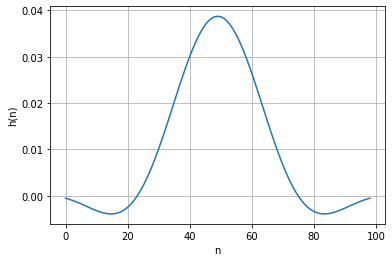

In [10]:
ans = x.value

h = np.zeros(N)
for m in range(1, M):
    h[M - m] = 0.5*ans[m]
    h[M + m] = 0.5*ans[m]
h[M] = ans[0]

# h[0]~0の場合はh[0]とh[N-1]を削除
if np.isclose(h[0], 0, atol=1e-14):
    h = h[1:1+(N-2)]
    N -= 2
    print(f'deleted! {N=}')

# 確認
fig, ax = plt.subplots()
ax.plot(h)
ax.set_xlabel('n')
ax.set_ylabel('h(n)')
ax.grid()

## 設計したローパスフィルタの確認
### （準備） FIRフィルタの定義

In [11]:
num = h # 分子の係数

den = np.zeros(N) # 分母の係数
den[0] = 1.0

sys = signal.TransferFunction(num, den, dt=Ts)

### 正弦波信号を入力してみる
振幅が1、周波数が1 Hz、20 Hz、40 Hzの3つの信号をFIRフィルタに入力して出力信号を確認します。

今回設計したFIRフィルタは、入力信号の周波数が10 Hz以下の場合は通過、30 Hz以上の場合は遮断するローパスフィルタです。
グラフから、1 Hzの場合は出力信号の振幅は入力信号からほとんど変わらず、40 Hzの場合は出力信号の振幅がほぼ0になって遮断されていることが確認できました。

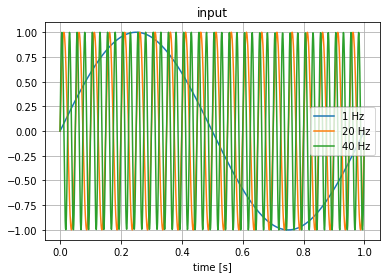

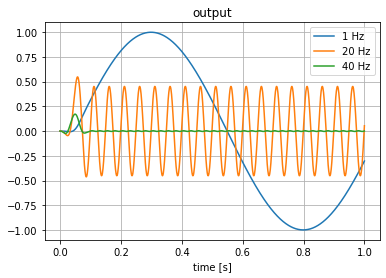

In [12]:
t = np.linspace(0, 1, int(1/Ts)) # 時間 [s]

# 入力信号
u1 = 1.0*np.sin(2*np.pi*1*t)
u20 = 1.0*np.sin(2*np.pi*20*t)
u40 = 1.0*np.sin(2*np.pi*40*t)

# FIRフィルタに入力信号u*を適用して、出力信号y*を求める
_, y1 = signal.dlsim(sys, u1) 
_, y20 = signal.dlsim(sys, u20)
_, y40 = signal.dlsim(sys, u40)

# plot
## 入力信号
fig, ax = plt.subplots()
ax.plot(t, u1, label='1 Hz')
ax.plot(t, u20, label='20 Hz')
ax.plot(t, u40, label='40 Hz')
ax.set_title('input')
ax.set_xlabel('time [s]')
ax.grid()
ax.legend()

## 出力信号
fig, ax = plt.subplots()
ax.plot(t, y1, label='1 Hz')
ax.plot(t, y20, label='20 Hz')
ax.plot(t, y40, label='40 Hz')
ax.set_title('output')
ax.set_xlabel('time [s]')
ax.grid()
ax.legend()

### 周波数応答
ボード線図で周波数応答を確認します。

Text(0, 0.5, 'phase [deg]')

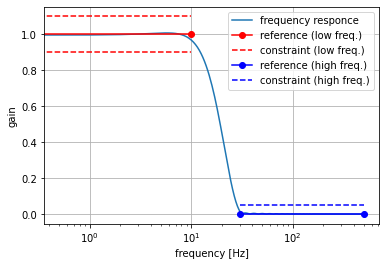

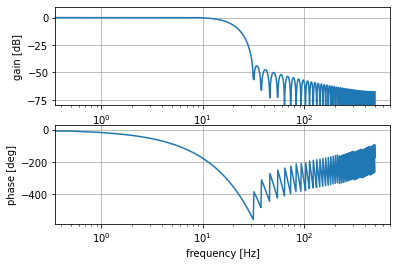

In [13]:
w, mag, phase = sys.bode(n=1000)

# plot
fig, ax = plt.subplots()
ax.semilogx(1/(2*np.pi)*w, 10**(mag/20), label='frequency responce')   # Bode magnitude plot
# 制約（通過側）
ax.semilogx([0, omega_p/(2*np.pi*Ts)], np.ones(2), 'ro-', label='reference (low freq.)')
ax.semilogx([0, omega_p/(2*np.pi*Ts)], (1-delta_p)*np.ones(2), 'r--', label='constraint (low freq.)')
ax.semilogx([0, omega_p/(2*np.pi*Ts)], (1+delta_p)*np.ones(2), 'r--')
# 制約 （遮断側）
ax.semilogx([omega_a/(2*np.pi*Ts), np.pi/(2*np.pi*Ts)],[0, 0], 'bo-', label='reference (high freq.)')
ax.semilogx([omega_a/(2*np.pi*Ts), np.pi/(2*np.pi*Ts)], delta_a*np.ones(2), 'b--', label='constraint (high freq.)')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('gain')
ax.grid()
ax.legend()


fig, axs = plt.subplots(2,1)
axs[0].semilogx(1/(2*np.pi)*w, mag)    # Bode magnitude plot
axs[0].grid()
axs[0].set_ylim([-80,10])
axs[0].set_ylabel('gain [dB]')
#-
axs[1].semilogx(1/(2*np.pi)*w, phase)  # Bode phase plot
axs[1].grid()
axs[1].set_xlabel('frequency [Hz]')
axs[1].set_ylabel('phase [deg]')

## 設計手法の詳細

### FIRフィルタの設計を2次計画問題に帰着する

---
次式の伝達関数で表されるFIRフィルタを考える。
$$
H(z) = \sum_{n=0}^{N-1}{h_{n}z^{-n}}
$$
$N$を奇数、かつ$n=0,2,...,N-1$に対して$h_n=h_{N-1-n}$が成り立つと仮定する（FIRフィルタは線形位相になる）。このとき次式が成り立つ
$$
H(e^{j\omega})
=e^{-j\omega\frac{N-1}{2}}\sum_{n=0}^{(N-1)/2}{a_n \cos n \omega}
=e^{-j\omega\frac{N-1}{2}}A(\omega),
$$
ここで、$a_0=h_{(N-1)/2}$、$a_n=2h_{(N-1)/2-n},\ n=1,2,...,(N-1)/2$。


実現したい線形位相FIRフィルタの周波数応答を$H_d(\omega)=e^{-j\omega(N-1)/2}A_d(\omega)$とする。
$H_d(\omega)$に対する$H(e^{j\omega})$の重み付き2乗誤差は次式となる
$$
e_l(x)=\int_{-\pi}^{\pi}{W(\omega) [A(\omega)-A_d(\omega)]^2d\omega}
$$
ここで、$W(\omega)\ge0$は重み関数、$x=[a_0,a_1,...,a_{(N-1)/2}]^T$。

$c_l(x)=[1, \cos\omega, \cos 2 \omega, ... , \cos ((N-1)\omega/2)]^T$と定義すると、$A(\omega)=x^Tc_l(\omega)$と書くことができる。$W(-\omega)=W(\omega)$と仮定すると、
$$
e_l(x) = 4\left[ (1/2)x^T Q_l x - x^T b_l+\mu \right]
$$
ここで、$\mu$は定数で、
$$
Q_l = \int_{0}^{\pi}{W(\omega)c_l(\omega)c_l^T(\omega) \ d\omega}, \\
b_l = \int_{0}^{\pi}{W(\omega)A_d(\omega)c_l(\omega) \ d\omega}.
$$

---
